# Q-Learning Tutorial - Frozen Lake
Welcome to Q-learning!
Today we'll be going through how to set up and run q-learning using both the Frozen Lake and Taxi examples from OpenAI Gym.

### Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from IPython.display import clear_output

In [2]:
import numpy as np

In [3]:
import torch

In [4]:
import gym

In [5]:
import time

In [6]:
from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78, # optimum = .8196
)

### Set-up
Here we select which environment to use. (We'll be using FrozenLakeNotSlippery first)

In [7]:
# Select your environment

#env = gym.make('FrozenLakeNotSlippery-v0')
#env = gym.make('FrozenLake-v0')
env = gym.make('Taxi-v3')

Next, we need to find the number of states and actions possible for this environment.

In [8]:
number_of_states=env.observation_space.n
number_of_actions=env.action_space.n

Once we have these values, we can use them to initialize our q-table.
You can see here that we're initiliazing it with all zeroes - during training, a vector with small random values will be added to lift the degeneracy in the q-values

In [9]:
# Initialize q-table
Q=torch.zeros([number_of_states,number_of_actions])

Now for our hyper-parameters.

gamma - tracks how much future reward should affect current decision making

In [10]:
# Set the gamma value
gamma=0.95

learning rate - affects how strongly the current and future rewards influence the updated q-value

In [11]:
# Set the learning rate
learning_rate=0.9

egreedy (epsilon) - determines to what extent newly acquired information overrides old information

egreedy_final - minimum epsilon value (at which point it stops decaying)

egreedy_decay - rate of decay of epsilon value

In [12]:
# Set the epsilon value
egreedy=0.9
egreedy_final=0.01
egreedy_decay=0.999

### Training

And now we can set up our training loop!

Outside the loop, you can see we're setting the number of episodes to 1000. (Feel free to play around with this to see the agent's progress after different amounts of training)

Action selection will be either random exploration or exploitation of the known Q-table values. The likelihood of each selection type is controlled by the epsilon parameter.

After an action is chosen, we update the Q-table according to the Bellman equation described last week.

After the agent reaches the goal for the first time, an animation of the agent's progress through the environment will be displayed below the code. A graphic depiction of the Q-table is also shown - as it explores more of the table, this image will change.

In [13]:
%%time

x_e = []
y_e = []

num_episodes=1000
reach_goal = False
#learning_rate=i
steps_total=np.full([num_episodes],-999,dtype=np.int32)
rewards_total=np.full([num_episodes],-999,dtype=np.float32)

for i_episode in range(num_episodes):
    
    # reset the state for the current episode
    state = env.reset()
    
    # keep track of how many steps have been taken in the episode
    step=0

    #undiscounted reward for the episode
    current_total_reward=0
    
    while True:

        step+=1

        # small random vector added to q-table values when selecting action
        Q_eps=1e-6*torch.randn([number_of_actions])
        
        random_for_egreedy=torch.rand(1).item()
        
        
        if random_for_egreedy>egreedy:
            # Exploitation - select largest value from q-table
            action=torch.argmax(Q[state]+Q_eps).item()
        else:
            # Exploration - random action selection
            action=env.action_space.sample()
        
        new_state, reward, done, info = env.step(action)

        current_total_reward+=reward
        
        if reward>0:
            reach_goal = True
        
        if egreedy>egreedy_final:
            egreedy*=egreedy_decay
        
        # Update the q-table using the Bellman equation
        Q[state,action]=(1.0-learning_rate)*Q[state,action]+learning_rate*(reward+gamma *torch.max(Q[new_state]).item())

        state=new_state
        clear_output(wait=True)
        
        # Once the goal has been reached, display animation of current episode every 50 episodes
        if reach_goal and (i_episode%50 == 0):
            time.sleep(0.3)
            print("------------------------")
            env.render() 
            print("++++++++++++++++++++++++")
            print('new state: ',new_state)
            print('Current reward',current_total_reward)
            plt.figure(figsize=(5,5))
            #print(Q.t())
            plt.imshow(Q, cmap='gray', aspect='auto')
            #plt.colorbar()
            plt.show()

        if done:
            steps_total[i_episode]=step
            rewards_total[i_episode]=current_total_reward
            print("Episode finished after: {}".format(step))
            time.sleep(0.1)
            break
            
x_e.append(torch.arange(len(rewards_total)))
y_e.append(rewards_total)

Episode finished after: 14
CPU times: user 1min 23s, sys: 7.19 s, total: 1min 30s
Wall time: 4min 48s


# Results
Let's take a look at the results.

First, let's look at the average reward value and number of steps from our training run.

In [14]:
print("Average number of steps: {}". format(np.average(steps_total)))

Average number of steps: 29.415


In [15]:
print("Average number of steps in last 100 episodes: {}". format(np.average(steps_total[-100:])))

Average number of steps in last 100 episodes: 13.39


In [16]:
print("Average total undiscounted reward {}".format(np.average(rewards_total)))

Average total undiscounted reward -19.28700065612793


In [17]:
print("Average total undiscounted reward in the last 100 episodes {}".format(np.average(rewards_total[-100:])))

Average total undiscounted reward in the last 100 episodes 7.25


We can take a look at the q-table now too. (Remember how it started with values of 0?)

In [18]:
print(Q)

tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [ -6.0349,  -6.1625,  -6.7223,  -6.1625,   5.2100, -10.7595],
        [ -5.4023,  -4.8277,   5.4095,  -4.8277,  10.9512,  -9.0000],
        ...,
        [ -3.3642,   9.2852,  -3.3642,  -3.5630,  -9.0000,  -9.0000],
        [ -5.5105,  -6.1321,  -5.5788,  -6.0133,  -9.0000,  -9.0000],
        [ -0.9000,  -1.7595,  -0.9000,  17.7939,  -9.0000,  -9.0000]])


It looks like its action-taking has become much clearer.

Next we're going to look at how the total reward varied by episode.

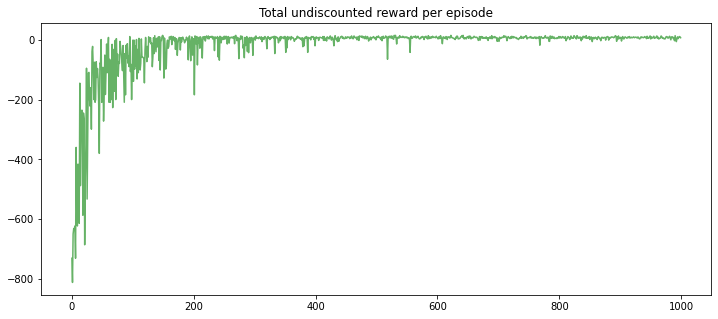

In [19]:
plt.figure(1,figsize=[12,5])
plt.title("Total undiscounted reward per episode")
plt.plot(torch.arange(len(rewards_total)), rewards_total,alpha=0.6, color='green')
#plt.plot(rewards_total)
plt.show()


It looks like after about 200 episodes it was on its way to learning to maximize its reward.

Now let's take a look at how the number of steps it took to finish varied by episode.

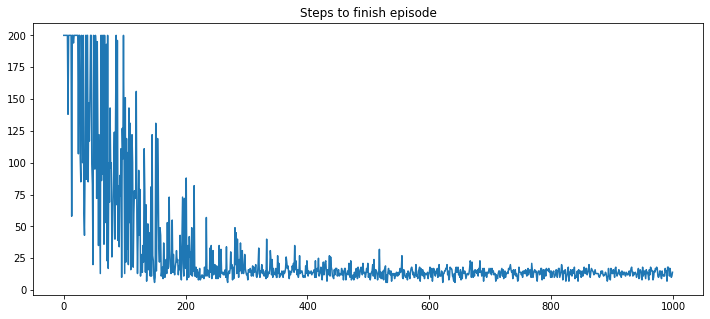

In [20]:
plt.figure(3,figsize=[12,5])
plt.title("Steps to finish episode")
plt.plot(steps_total)
plt.show()

After about 200 episodes, it looks like it found an optimal way to cross the frozen lake in 6 steps.